In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, precision_recall_fscore_support
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, BatchNormalization, 
    Reshape, LSTM, Dense, Dropout
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

# Load dataset
spoof_dataset = pd.read_csv('../spoof_features.csv')
bonfide_dataset = pd.read_csv('../bonafide_features.csv')


In [2]:
# Add label columns: 0 for spoof, 1 for bonafide
spoof_dataset['label'] = 0
bonfide_dataset['label'] = 1

# Merge the datasets
combined_dataset = pd.concat([spoof_dataset, bonfide_dataset], ignore_index=True)

# Shuffle the dataset (optional but recommended)
dataset = combined_dataset.sample(frac=1, random_state=42).reset_index(drop=True)

# Preview the result
print(dataset.head())
print(dataset['label'].value_counts())


       MFCC_1      MFCC_2     MFCC_3     MFCC_4     MFCC_5     MFCC_6  \
0 -321.300079   68.924034 -11.630466  15.247277   0.081929  -5.355102   
1 -302.844330  152.462219  -3.850286  22.434635  16.894335  28.037649   
2 -310.625214  131.728531  -2.207699  26.260344  -0.560494   9.410127   
3 -291.440430  104.713844  -3.233987  14.494747  22.734116   4.006812   
4 -236.143478   60.710751  22.075727  20.185877   1.931249  12.823346   

      MFCC_7     MFCC_8     MFCC_9   MFCC_10  ...  Spectral_Contrast_5  \
0  -2.240336  -3.254134 -11.073352 -0.462968  ...            18.296619   
1  -8.635355  -5.007866  -1.507605 -2.067190  ...            19.450157   
2 -10.213823  -0.769273  -4.603554 -2.057283  ...            20.092984   
3  -6.256077   4.401022 -14.231632  4.887247  ...            18.035892   
4 -13.016880  15.969530 -11.725241 -4.370944  ...            16.998374   

   Spectral_Contrast_6  Spectral_Contrast_7  Tonnetz_1  Tonnetz_2  Tonnetz_3  \
0            25.020027            32

In [3]:
# Extract features and target
X = dataset.iloc[:, :-1]  # Features
y = dataset['label']     # Target

In [4]:
import joblib
# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Save the label encoder
#joblib.dump(label_encoder, 'label_encoder.pkl')
#print("Label encoder saved as 'label_encoder.pkl'.")

In [5]:
# Compute class weights for imbalanced dataset
class_weights = compute_class_weight('balanced', classes=np.unique(y_encoded), y=y_encoded)
class_weights = dict(enumerate(class_weights))

In [6]:
# Normalize features
# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Save the scaler
#joblib.dump(scaler, 'scaler.pkl')
#print("Scaler saved as 'scaler.pkl'.")

In [7]:
# First split: train + temp (validation + test)
X_train_full, X_temp, y_train_full, y_temp = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

num_features = X_train_full.shape[1]

# Second split: validation + test from temp
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Train shape: {X_train_full.shape}, Validation shape: {X_val.shape}, Test shape: {X_test.shape}")


Train shape: (19162, 192), Validation shape: (4106, 192), Test shape: (4107, 192)


In [8]:
#Define CNN-LSTM model
input_shape = (num_features, 1, 1)
inputs = Input(shape=input_shape, name='input_layer')

x = Conv2D(64, (3, 1), activation='relu')(inputs)
x = MaxPooling2D((2, 1))(x)
x = BatchNormalization()(x)

x = Conv2D(128, (5, 1), activation='relu')(x)
x = MaxPooling2D((2, 1))(x)
x = BatchNormalization()(x)

reshape_dim = x.shape[1]
x = Reshape((reshape_dim, -1))(x)
x = LSTM(128, return_sequences=False)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
outputs = Dense(len(np.unique(y_encoded)), activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 192, 1, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 190, 1, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 95, 1, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 95, 1, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 91, 1, 128)     │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 1, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 45, 1, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 45, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 190,466 (744.01 KB)

 Trainable params: 190,082 (742.51 KB)

 Non-trainable params: 384 (1.50 KB)

In [9]:
X_train_full = X_train_full.reshape(-1, num_features, 1, 1)
X_val = X_val.reshape(-1, num_features, 1, 1)
X_test = X_test.reshape(-1, num_features, 1, 1)


In [10]:
history = model.fit(
    X_train_full, y_train_full,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val),
    class_weight=class_weights
)


Epoch 1/20
599/599 ━━━━━━━━━━━━━━━━━━━━ 45s 64ms/step - accuracy: 0.9822 - loss: 0.4534 - val_accuracy: 0.9971 - val_loss: 0.0222
Epoch 2/20
599/599 ━━━━━━━━━━━━━━━━━━━━ 38s 64ms/step - accuracy: 0.9988 - loss: 0.0117 - val_accuracy: 0.9978 - val_loss: 0.0090
Epoch 3/20
599/599 ━━━━━━━━━━━━━━━━━━━━ 26s 44ms/step - accuracy: 0.9987 - loss: 0.0099 - val_accuracy: 0.9929 - val_loss: 0.0318
Epoch 4/20
599/599 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - accuracy: 0.9992 - loss: 0.0100 - val_accuracy: 0.9995 - val_loss: 0.0035
Epoch 5/20
599/599 ━━━━━━━━━━━━━━━━━━━━ 22s 37ms/step - accuracy: 0.9990 - loss: 0.0077 - val_accuracy: 1.0000 - val_loss: 0.0024
Epoch 6/20
599/599 ━━━━━━━━━━━━━━━━━━━━ 23s 39ms/step - accuracy: 0.9991 - loss: 0.0063 - val_accuracy: 0.9995 - val_loss: 0.0036
Epoch 7/20
599/599 ━━━━━━━━━━━━━━━━━━━━ 23s 39ms/step - accuracy: 0.9995 - loss: 0.0054 - val_accuracy: 1.0000 - val_loss: 0.0017
Epoch 8/20
599/599 ━━━━━━━━━━━━━━━━━━━━ 22s 37ms/step - accuracy: 0.9998 - loss: 0.0028 - 

In [11]:
# 5. Evaluate
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f"\nValidation Accuracy: {val_accuracy * 100:.2f}%, Loss: {val_loss:.4f}")

test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%, Loss: {test_loss:.4f}")


Validation Accuracy: 100.00%, Loss: 0.0016
Test Accuracy: 99.98%, Loss: 0.0038


In [12]:
# 6. Predictions and Classification Report
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print("\nCNN-LSTM Test Classification Report:\n")
target_names = [str(class_label) for class_label in label_encoder.classes_]
print(classification_report(y_test, y_pred_classes, target_names=target_names))


129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step

CNN-LSTM Test Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2175
           1       1.00      1.00      1.00      1932

    accuracy                           1.00      4107
   macro avg       1.00      1.00      1.00      4107
weighted avg       1.00      1.00      1.00      4107



In [13]:
# 7. Validation Set Classification Report
y_val_pred = model.predict(X_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)

print("\nCNN-LSTM Validation Classification Report:\n")
print(classification_report(y_val, y_val_pred_classes, target_names=target_names))


129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step

CNN-LSTM Validation Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2175
           1       1.00      1.00      1.00      1931

    accuracy                           1.00      4106
   macro avg       1.00      1.00      1.00      4106
weighted avg       1.00      1.00      1.00      4106



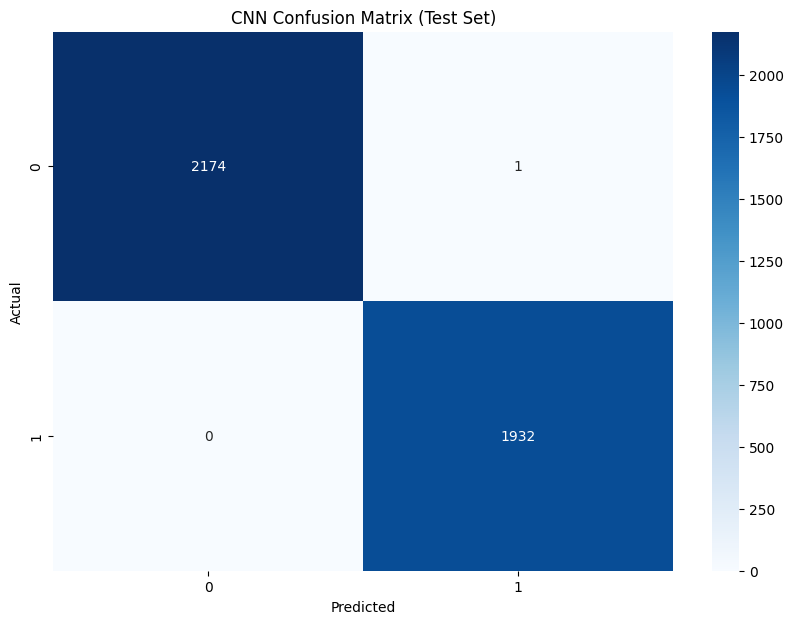

In [14]:
# 7. Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('CNN Confusion Matrix (Test Set)')
plt.show()

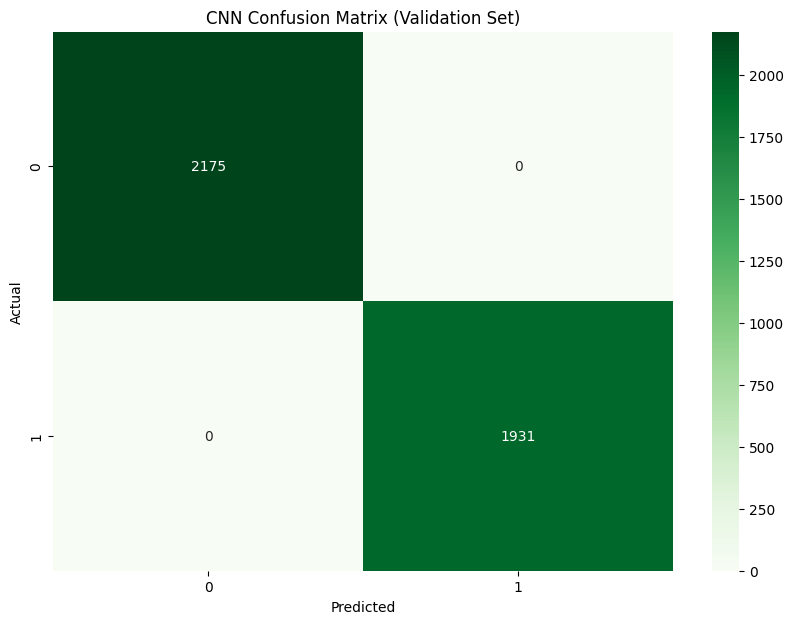

In [15]:
# 8. Confusion Matrix (Validation Set)
val_conf_matrix = confusion_matrix(y_val, y_val_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(val_conf_matrix, annot=True, fmt='d', cmap='Greens',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('CNN Confusion Matrix (Validation Set)')
plt.show()

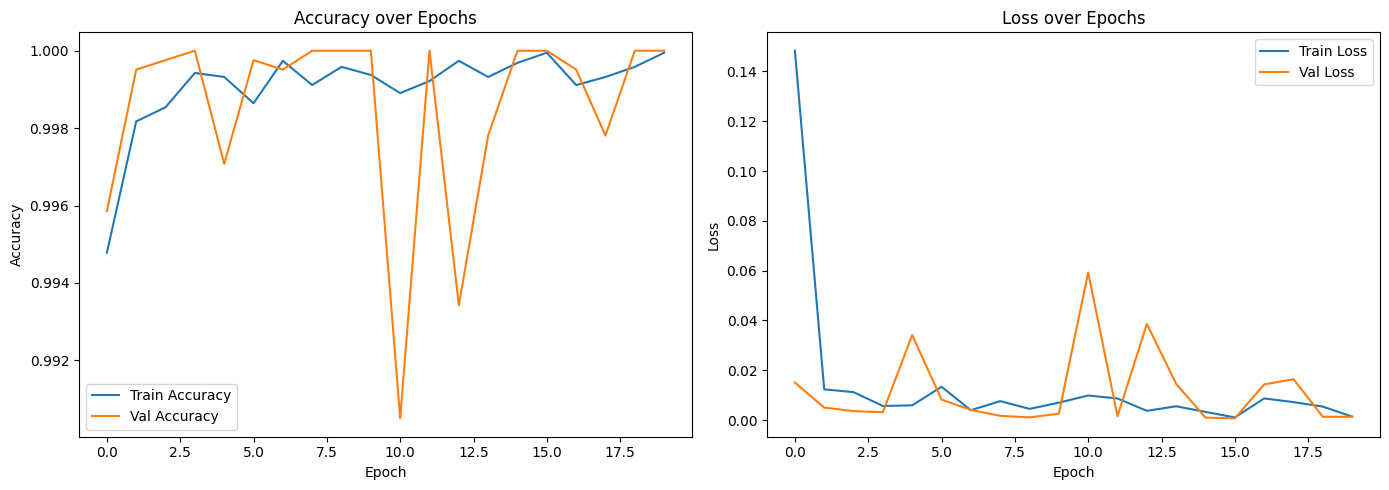

In [14]:
# 8. Plot Training History
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
# Save model
model.save('cnn-model.keras')